# Cython vs Python: a simple study case

In this notebook I present a simple study case of cython versus python performance. Three problems are considered:

1. A simple operation involving 1d arrays (e.g, compute the mean of a 1d array)
2. A more complex problem involving a 2d array: This is the classical computation of a pedestal, using the mean of the waveform, and then returning the pedestal-subtracted waveform normalized to some calibration constants. The data is a 2d array, with one axis running over sensors and the other representing each sensor waveform.
3. An even more complex problem where a MAU is used to compute the pedestal and then subtract it or return values above pedetal + MAU


In [18]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-12-01 08:46:57


In [369]:
from scipy import signal

In [7]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## 1.  Simple operation (mean of a vector): python, cython and python + numpy

In [432]:
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 10000)

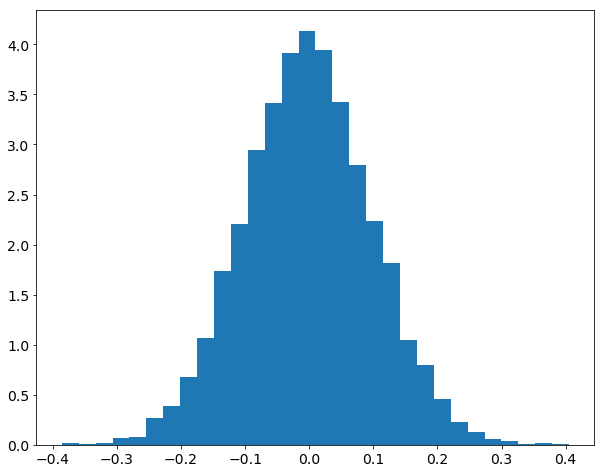

In [433]:
count, bins, ignored = plt.hist(s, 30, normed=True)

### Python

In [434]:
def python_mean(v):
    """Compute the mean of vector v using loop"""
    pmean = 0
    lv = len(v)
    for k in range(lv):
        pmean += v[k]
    pmean /= lv
    return pmean

In [435]:
print(python_mean(s))

-0.00212340609707


In [436]:
%timeit python_mean(s)

1.47 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Using numpy

In [437]:
def mean_np(v):
    """Compute the mean of vector v using np"""
    return np.mean(v)

In [438]:
print(mean_np(s))

-0.00212340609707


In [439]:
%timeit mean_np(s)

8.93 µs ± 511 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [440]:
%timeit np.mean(s)

8.81 µs ± 384 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [441]:
print('python + np / python = {}'.format(1.5e-3 /9e-6 ))

python + np / python = 166.66666666666666


#### Using np.mean() is ~166 times faster than naive mean in python. 

### Using cython

In [442]:
%%cython 
cpdef float cython_mean(double [:] v):
    """Compute the mean of vector v using loop"""
    cdef float pmean = 0
    cdef int lv = len(v)
    cdef int k
    for k in range(lv):
        pmean += v[k]
    pmean /= lv
    return pmean


In [443]:
print(cython_mean(s))

-0.0021234049927443266


In [444]:
%timeit cython_mean(s)

39 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [445]:
print('python + np / cython = {}'.format(39e-6 /9e-6 ))

python + np / cython = 4.333333333333333


#### Using python + np is 4 times faster than using naive cython

## 2. A more realistic case. Subtract baseline and normalise to calibration constants

### Data definition: consider an array sipm of 40 sipm, with a waveform of 100 samples

In [446]:
nsipm = 40
wfl = 100
sipm = np.zeros(nsipm * wfl, dtype=np.int16)
sipm = np.reshape(sipm,(nsipm,wfl))
for i in range(nsipm):
    sipm[i,:] = np.random.normal(100+i*10, 1, wfl)

print('sipm array = {}'.format(sipm))
NSiPM = sipm.shape[0]
NSiWF = sipm.shape[1]
print('NSiPM = {}, NSiWF = {}'.format(NSiPM, NSiWF))
print('baselines = {}'.format(np.mean(sipm,axis=1)))

sipm array = [[100  99 100 ...,  98  99 101]
 [110 111 110 ..., 110 111 111]
 [120 120 120 ..., 120 121 120]
 ..., 
 [468 470 469 ..., 471 470 471]
 [479 478 480 ..., 479 480 479]
 [490 490 490 ..., 490 489 489]]
NSiPM = 40, NSiWF = 100
baselines = [  99.55  109.68  119.48  129.37  139.61  149.55  159.55  169.6   179.57
  189.51  199.54  209.63  219.41  229.62  239.6   249.36  259.27  269.56
  279.57  289.39  299.3   309.56  319.47  329.65  339.45  349.55  359.55
  369.5   379.42  389.49  399.49  409.37  419.43  429.52  439.43  449.47
  459.29  469.59  479.36  489.64]


In [447]:
np.mean(sipm, axis=1)

array([  99.55,  109.68,  119.48,  129.37,  139.61,  149.55,  159.55,
        169.6 ,  179.57,  189.51,  199.54,  209.63,  219.41,  229.62,
        239.6 ,  249.36,  259.27,  269.56,  279.57,  289.39,  299.3 ,
        309.56,  319.47,  329.65,  339.45,  349.55,  359.55,  369.5 ,
        379.42,  389.49,  399.49,  409.37,  419.43,  429.52,  439.43,
        449.47,  459.29,  469.59,  479.36,  489.64])

### And calibration constants for each SiPM

In [448]:
adc_to_pes = np.abs(np.random.normal(1, 0.01, nsipm))
print('adc_to_pes = {}'.format(adc_to_pes))

adc_to_pes = [ 0.99837047  0.97951991  1.01232185  0.99994289  0.98687132  0.98458819
  1.01628343  1.02097536  0.9909171   1.00864264  1.006866    0.9869911
  1.00171909  0.99573359  0.98178904  1.0131474   0.99764482  0.98913378
  0.9911122   0.99482352  0.98360195  0.98240489  0.99409501  0.99107535
  1.00851573  0.99411551  1.00606028  0.9897853   1.00064013  1.01720575
  1.00223264  0.99385143  1.01148439  1.00922862  0.99799809  0.99566014
  1.00629834  1.00054769  1.0180636   1.00272275]


## Subtract baseline and normalize to adc

### Python

In [449]:
def python_sipm_subtract_baseline_and_normalize_to_adc(sipm, adc_to_pes):
    
    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    bl = np.zeros(NSiPM)
   
    for j in range(NSiPM):
        pmean = 0
        for k in range(NSiWF):
            pmean += sipm[j,k]
        pmean /= NSiWF
        
        bl[j] = pmean
        
        for k in range(NSiWF):
                siwf[j,k] = (sipm[j,k] - pmean) / adc_to_pes[j]
        
    
    return bl, siwf 

In [450]:
bl, wf = python_sipm_subtract_baseline_and_normalize_to_adc(sipm, adc_to_pes)
print('baselines = {}'.format(bl))
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

baselines = [  99.55  109.68  119.48  129.37  139.61  149.55  159.55  169.6   179.57
  189.51  199.54  209.63  219.41  229.62  239.6   249.36  259.27  269.56
  279.57  289.39  299.3   309.56  319.47  329.65  339.45  349.55  359.55
  369.5   379.42  389.49  399.49  409.37  419.43  429.52  439.43  449.47
  459.29  469.59  479.36  489.64]
SiPMs = [[ 0.45073448 -0.5508977   0.45073448 ..., -1.55252989 -0.5508977
   1.45236667]
 [ 0.32669065  1.34759895  0.32669065 ...,  0.32669065  1.34759895
   1.34759895]
 [ 0.51367063  0.51367063  0.51367063 ...,  0.51367063  1.50149876
   0.51367063]
 ..., 
 [-1.58912965  0.40977557 -0.58967704 ...,  1.40922818  0.40977557
   1.40922818]
 [-0.35361249 -1.33586939  0.62864442 ..., -0.35361249  0.62864442
  -0.35361249]
 [ 0.35902247  0.35902247  0.35902247 ...,  0.35902247 -0.63826217
  -0.63826217]]


array([  2.81774604e-15,  -6.98108238e-15,  -3.92685884e-15,
        -4.57300864e-15,  -1.38467016e-14,  -1.15452092e-14,
        -1.11755050e-14,   5.62216940e-15,   6.88338275e-15,
         9.00612918e-15,   7.92255150e-15,   4.61852778e-15,
         3.45057316e-15,  -4.62074823e-15,   5.71986902e-15,
        -1.34658951e-14,   1.82009963e-14,  -2.36921593e-15,
         6.94500013e-15,   1.37145850e-14,  -1.15929488e-14,
        -2.34257058e-15,  -2.74624767e-14,   2.29793962e-14,
         1.13220544e-14,  -1.14241949e-14,  -1.12887477e-14,
        -8.88178420e-18,  -1.58562052e-14,  -8.95949981e-15,
        -9.06219544e-15,  -4.57966998e-15,  -6.75237644e-15,
         1.80366833e-14,  -6.87894186e-15,  -2.74136269e-14,
        -2.03081996e-14,   2.49911203e-14,  -1.33892897e-14,
         1.35957912e-14])

In [451]:
%timeit python_sipm_subtract_baseline_and_normalize_to_adc_2l(sipm, adc_to_pes)

11.6 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Python: using numpy

In [452]:
def python_sipm_subtract_baseline_and_normalize_to_adc_np(sipm, adc_to_pes):
    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    bl = np.mean(sipm, axis=1)
    for i in range(NSiPM):
        siwf[i] = (sipm[i] - bl[i]) / adc_to_pes[i]
    
    return bl, siwf

In [453]:
bl, wf = python_sipm_subtract_baseline_and_normalize_to_adc_np(sipm, adc_to_pes)
print('baselines = {}'.format(bl))
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

baselines = [  99.55  109.68  119.48  129.37  139.61  149.55  159.55  169.6   179.57
  189.51  199.54  209.63  219.41  229.62  239.6   249.36  259.27  269.56
  279.57  289.39  299.3   309.56  319.47  329.65  339.45  349.55  359.55
  369.5   379.42  389.49  399.49  409.37  419.43  429.52  439.43  449.47
  459.29  469.59  479.36  489.64]
SiPMs = [[ 0.45073448 -0.5508977   0.45073448 ..., -1.55252989 -0.5508977
   1.45236667]
 [ 0.32669065  1.34759895  0.32669065 ...,  0.32669065  1.34759895
   1.34759895]
 [ 0.51367063  0.51367063  0.51367063 ...,  0.51367063  1.50149876
   0.51367063]
 ..., 
 [-1.58912965  0.40977557 -0.58967704 ...,  1.40922818  0.40977557
   1.40922818]
 [-0.35361249 -1.33586939  0.62864442 ..., -0.35361249  0.62864442
  -0.35361249]
 [ 0.35902247  0.35902247  0.35902247 ...,  0.35902247 -0.63826217
  -0.63826217]]


array([  2.81774604e-15,  -6.98108238e-15,  -3.92685884e-15,
        -4.57300864e-15,  -1.38467016e-14,  -1.15452092e-14,
        -1.11755050e-14,   5.62216940e-15,   6.88338275e-15,
         9.00612918e-15,   7.92255150e-15,   4.61852778e-15,
         3.45057316e-15,  -4.62074823e-15,   5.71986902e-15,
        -1.34658951e-14,   1.82009963e-14,  -2.36921593e-15,
         6.94500013e-15,   1.37145850e-14,  -1.15929488e-14,
        -2.34257058e-15,  -2.74624767e-14,   2.29793962e-14,
         1.13220544e-14,  -1.14241949e-14,  -1.12887477e-14,
        -8.88178420e-18,  -1.58562052e-14,  -8.95949981e-15,
        -9.06219544e-15,  -4.57966998e-15,  -6.75237644e-15,
         1.80366833e-14,  -6.87894186e-15,  -2.74136269e-14,
        -2.03081996e-14,   2.49911203e-14,  -1.33892897e-14,
         1.35957912e-14])

In [454]:
%timeit python_sipm_subtract_baseline_and_normalize_to_adc_np(sipm, adc_to_pes)

188 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [455]:
print('python + np / python = {}'.format(11.6e-3 /188e-6 ))

python + np / python = 61.702127659574465


#### Numpy accelerates calculation by a factor 60

### Cython using loops

In [456]:
%%cython 
cimport numpy as np
import  numpy as np
from scipy import signal

cdef double cmean(double [:] v):
    cdef int  k
    cdef int N = len(v)
    cdef double pmean = 0
    
    for k in range(N):
        pmean += v[k]
    pmean /= N
    return pmean

cpdef cython_sipm_subtract_baseline_and_normalize(np.ndarray[np.int16_t, ndim=2]sipm, 
                                                            np.ndarray[np.float64_t, ndim=1] adc_to_pes):
    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:]    bl = np.zeros(NSiPM)
   
    cdef int j, k
    cdef double pmean
    for j in range(NSiPM):
        pmean = cmean(SiWF[j])
        bl[j] = pmean
        
        for k in range(NSiWF):
                siwf[j,k] = (SiWF[j,k] - pmean) / adc_to_pes[j]
        
    
    return np.asarray(bl), np.asarray(siwf) 

cpdef cython_sipm_subtract_baseline_and_normalize_np(np.ndarray[np.int16_t, ndim=2]sipm, 
                                                            np.ndarray[np.float64_t, ndim=1] adc_to_pes):
    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:]    bl = np.zeros(NSiPM)
   
    cdef int j, k
    cdef double pmean
    for j in range(NSiPM):
        pmean = np.mean(SiWF[j])
        bl[j] = pmean
        
        for k in range(NSiWF):
                siwf[j,k] = (SiWF[j,k] - pmean) / adc_to_pes[j]
        
    
    return np.asarray(bl), np.asarray(siwf) 




In [457]:
bl, wf = cython_sipm_subtract_baseline_and_normalize(sipm, adc_to_pes)
print('baselines = {}'.format(bl))
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

baselines = [  99.55  109.68  119.48  129.37  139.61  149.55  159.55  169.6   179.57
  189.51  199.54  209.63  219.41  229.62  239.6   249.36  259.27  269.56
  279.57  289.39  299.3   309.56  319.47  329.65  339.45  349.55  359.55
  369.5   379.42  389.49  399.49  409.37  419.43  429.52  439.43  449.47
  459.29  469.59  479.36  489.64]
SiPMs = [[ 0.45073448 -0.5508977   0.45073448 ..., -1.55252989 -0.5508977
   1.45236667]
 [ 0.32669065  1.34759895  0.32669065 ...,  0.32669065  1.34759895
   1.34759895]
 [ 0.51367063  0.51367063  0.51367063 ...,  0.51367063  1.50149876
   0.51367063]
 ..., 
 [-1.58912965  0.40977557 -0.58967704 ...,  1.40922818  0.40977557
   1.40922818]
 [-0.35361249 -1.33586939  0.62864442 ..., -0.35361249  0.62864442
  -0.35361249]
 [ 0.35902247  0.35902247  0.35902247 ...,  0.35902247 -0.63826217
  -0.63826217]]


array([  2.81774604e-15,  -6.98108238e-15,  -3.92685884e-15,
        -4.57300864e-15,  -1.38467016e-14,  -1.15452092e-14,
        -1.11755050e-14,   5.62216940e-15,   6.88338275e-15,
         9.00612918e-15,   7.92255150e-15,   4.61852778e-15,
         3.45057316e-15,  -4.62074823e-15,   5.71986902e-15,
        -1.34658951e-14,   1.82009963e-14,  -2.36921593e-15,
         6.94500013e-15,   1.37145850e-14,  -1.15929488e-14,
        -2.34257058e-15,  -2.74624767e-14,   2.29793962e-14,
         1.13220544e-14,  -1.14241949e-14,  -1.12887477e-14,
        -8.88178420e-18,  -1.58562052e-14,  -8.95949981e-15,
        -9.06219544e-15,  -4.57966998e-15,  -6.75237644e-15,
         1.80366833e-14,  -6.87894186e-15,  -2.74136269e-14,
        -2.03081996e-14,   2.49911203e-14,  -1.33892897e-14,
         1.35957912e-14])

In [458]:
%timeit cython_sipm_subtract_baseline_and_normalize(sipm, adc_to_pes)

34.7 µs ± 797 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [459]:
bl, wf = cython_sipm_subtract_baseline_and_normalize_np(sipm, adc_to_pes)
print('baselines = {}'.format(bl))
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

baselines = [  99.55  109.68  119.48  129.37  139.61  149.55  159.55  169.6   179.57
  189.51  199.54  209.63  219.41  229.62  239.6   249.36  259.27  269.56
  279.57  289.39  299.3   309.56  319.47  329.65  339.45  349.55  359.55
  369.5   379.42  389.49  399.49  409.37  419.43  429.52  439.43  449.47
  459.29  469.59  479.36  489.64]
SiPMs = [[ 0.45073448 -0.5508977   0.45073448 ..., -1.55252989 -0.5508977
   1.45236667]
 [ 0.32669065  1.34759895  0.32669065 ...,  0.32669065  1.34759895
   1.34759895]
 [ 0.51367063  0.51367063  0.51367063 ...,  0.51367063  1.50149876
   0.51367063]
 ..., 
 [-1.58912965  0.40977557 -0.58967704 ...,  1.40922818  0.40977557
   1.40922818]
 [-0.35361249 -1.33586939  0.62864442 ..., -0.35361249  0.62864442
  -0.35361249]
 [ 0.35902247  0.35902247  0.35902247 ...,  0.35902247 -0.63826217
  -0.63826217]]


array([  2.81774604e-15,  -6.98108238e-15,  -3.92685884e-15,
        -4.57300864e-15,  -1.38467016e-14,  -1.15452092e-14,
        -1.11755050e-14,   5.62216940e-15,   6.88338275e-15,
         9.00612918e-15,   7.92255150e-15,   4.61852778e-15,
         3.45057316e-15,  -4.62074823e-15,   5.71986902e-15,
        -1.34658951e-14,   1.82009963e-14,  -2.36921593e-15,
         6.94500013e-15,   1.37145850e-14,  -1.15929488e-14,
        -2.34257058e-15,  -2.74624767e-14,   2.29793962e-14,
         1.13220544e-14,  -1.14241949e-14,  -1.12887477e-14,
        -8.88178420e-18,  -1.58562052e-14,  -8.95949981e-15,
        -9.06219544e-15,  -4.57966998e-15,  -6.75237644e-15,
         1.80366833e-14,  -6.87894186e-15,  -2.74136269e-14,
        -2.03081996e-14,   2.49911203e-14,  -1.33892897e-14,
         1.35957912e-14])

In [460]:
%timeit cython_sipm_subtract_baseline_and_normalize_np(sipm, adc_to_pes)

386 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [461]:
print('cython + np / python + np = {}'.format(386e-6 /188e-6 ))

cython + np / python + np = 2.0531914893617023


#### A non intuitive result! Using np IN CYTHON, for a complex problem can actually SLOW DOWN performance

In [463]:
print('cython  / python + np = {}'.format(188e-6 /35e-6 ))

cython  / python + np = 5.371428571428572


#### Using pure cython improves the performance of python + np by a factor 5

In [465]:
print('cython  / python + np = {}'.format(11.2e-3 /35e-6 ))

cython  / python + np = 320.0


#### And the performance of naive python by a factor 320

## 3. USING MAUs

### Python version

In [466]:
def python_sipm_signal_above_thr_mau(sipm, adc_to_pes, thr, n_MAU=100):
    """
    subtracts the baseline
    Uses a MAU to set the signal threshold (thr, in PES)
    returns ZS waveforms for all SiPMs

    setting Cal to a non zero value invokes calibration mode
    where the unselected time bins are returned as they are
    instead of set to zero.

    """

    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    SiWF = sipm.astype(np.double)
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    MAU_ = np.zeros(NSiWF, dtype=np.double)
    thrs = np.full(NSiPM, thr)
    

    # loop over all SiPMs. Skip any SiPM with adc_to_pes constant = 0
    # since this means SiPM is dead
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            continue

        # compute and subtract the baseline
        pmean = np.mean(SiWF[j])

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])

        # threshold using the MAU
        if SiWF[j,k]  > MAU_[k] + thrs[j] * adc_to_pes[j]:
            siwf[j,k] = SiWF[j,k] / adc_to_pes[j]

    return siwf

In [467]:
wf = python_sipm_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

SiPMs = [[ 0.          0.          0.         ...,  0.          0.          1.45236667]
 [ 0.          0.          0.         ...,  0.          0.          1.34759895]
 [ 0.          0.          0.         ...,  0.          0.          0.51367063]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          1.40922818]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


array([ 0.01452367,  0.01347599,  0.00513671,  0.        ,  0.01408492,
        0.00457044,  0.        ,  0.01371238,  0.        ,  0.02468664,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00433856,  0.00613174,
        0.        ,  0.01465791,  0.        ,  0.        ,  0.01536912,
        0.        ,  0.00447289,  0.        ,  0.00579629,  0.01484459,
        0.        ,  0.        ,  0.00563528,  0.        ,  0.00571143,
        0.        ,  0.        ,  0.01409228,  0.        ,  0.        ])

In [468]:
%timeit python_sipm_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

4.25 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cython version

In [469]:
%%cython 
cimport numpy as np
import  numpy as np
from scipy import signal

cdef double cmean(double [:] v):
    cdef int  k
    cdef int N = len(v)
    cdef double pmean = 0
    
    for k in range(N):
        pmean += v[k]
    pmean /= N
    return pmean

cdef cmau(double [:, :] SiWF, int j, double pmean, int n_MAU=100):
    
    cdef int NSiWF = SiWF.shape[1]
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef double [:] MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    cdef int k
    
    for k in range(NSiWF):
        SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])
    
    return MAU_



cpdef sipm_subtract_baseline_and_normalize_mau(np.ndarray[np.int16_t, ndim=2] sipm,
                                               np.ndarray[np.float64_t, ndim=1] adc_to_pes,
                                               int n_MAU=100):
    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:] MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef int j, k
    cdef double pmean

    for j in range(NSiPM):
        pmean = cmean(SiWF[j])
        #MAU_ = cmau(SiWF, j, pmean, n_MAU=100)  # calling this function increases time by factor 100

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])

        for k in range(NSiWF):
            SiWF[j,k] = (SiWF[j,k] - MAU_[k]) / adc_to_pes[j]

    return np.asarray(SiWF)

cpdef sipm_signal_above_thr_mau(np.ndarray[np.int16_t, ndim=2] sipm,
                  np.ndarray[np.float64_t, ndim=1] adc_to_pes, double thr,
                  int n_MAU=100):
    """
    subtracts the baseline
    Uses a MAU to set the signal threshold (thr, in PES)
    returns ZS waveforms for all SiPMs

    setting Cal to a non zero value invokes calibration mode
    where the unselected time bins are returned as they are
    instead of set to zero.

    """

    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:] MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef int j, k
    cdef double pmean
    cdef double [:] thrs = np.full(NSiPM, thr)
    

    # loop over all SiPMs. Skip any SiPM with adc_to_pes constant = 0
    # since this means SiPM is dead
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            continue

        # compute and subtract the baseline
        pmean = cmean(SiWF[j])

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])

        # threshold using the MAU
        if SiWF[j,k]  > MAU_[k] + thrs[j] * adc_to_pes[j]:
            siwf[j,k] = SiWF[j,k] / adc_to_pes[j]

    return np.asarray(siwf)


In [470]:
wf = sipm_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

SiPMs = [[ 0.          0.          0.         ...,  0.          0.          1.45236667]
 [ 0.          0.          0.         ...,  0.          0.          1.34759895]
 [ 0.          0.          0.         ...,  0.          0.          0.51367063]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          1.40922818]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


array([ 0.01452367,  0.01347599,  0.00513671,  0.        ,  0.01408492,
        0.00457044,  0.        ,  0.01371238,  0.        ,  0.02468664,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00433856,  0.00613174,
        0.        ,  0.01465791,  0.        ,  0.        ,  0.01536912,
        0.        ,  0.00447289,  0.        ,  0.00579629,  0.01484459,
        0.        ,  0.        ,  0.00563528,  0.        ,  0.00571143,
        0.        ,  0.        ,  0.01409228,  0.        ,  0.        ])

In [471]:
%timeit sipm_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

2.82 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [472]:
print('python + scipy mau/cython + scipy mau = {}'.format(4.25/2.82))

python + scipy mau/cython + scipy mau = 1.5070921985815604


#### The calculation using Scipy is only 1.5 times slower in python than in cython. 

In [475]:
print('mau/pedestal = {}'.format(2.82e-3/35e-6))

mau/pedestal = 80.57142857142858


#### Using MAUS is a factor 80 slower than using normal pedestal subtraction 

In [476]:
wf = sipm_subtract_baseline_and_normalize_mau(sipm, adc_to_pes, n_MAU=20)
print('SiPMs = {}'.format(wf))
np.mean(wf,axis=1)

SiPMs = [[ 0.42819776 -0.54588954  0.43320592 ..., -1.40228506 -0.45073448
   1.45236667]
 [ 0.31035612  1.26388447  0.22664164 ...,  0.25522707  1.27613537
   1.27613537]
 [ 0.4879871   0.46230357  0.43662004 ...,  0.79026251  1.62991642
   0.54330547]
 ..., 
 [-1.50967317  0.46874327 -0.50122548 ...,  1.29928839  0.24986315
   1.34926102]
 [-0.33593186 -1.25139529  0.68168629 ..., -0.63846699  0.34378992
  -0.63846699]
 [ 0.34107135  0.32312022  0.3051691  ...,  0.         -0.94742041
  -0.84769195]]


array([ -1.77789713e-02,   1.57219878e-02,   2.65725768e-02,
         1.03505912e-02,  -2.37619631e-02,  -2.53913264e-04,
        -2.70593806e-03,   1.76302003e-02,  -8.22470415e-03,
         3.47496711e-02,   2.35383854e-02,  -2.36577616e-02,
        -3.58883048e-02,  -4.86073789e-02,   1.37504081e-02,
        -1.97404642e-04,  -1.61881260e-02,   3.36658203e-02,
         2.65862937e-02,  -2.92011592e-02,  -2.28751071e-02,
         1.55740267e-02,   4.00867116e-02,  -2.27026130e-03,
         7.68456038e-03,  -2.26331846e-03,  -7.20632767e-03,
        -1.11135213e-02,   2.40845828e-02,   2.74772336e-02,
        -4.98886168e-05,  -1.07158873e-02,   2.23928321e-02,
        -3.96342309e-04,   2.87074698e-02,   2.09408806e-02,
        -7.00587459e-03,   2.74349741e-02,   2.63244850e-02,
         1.61560112e-02])

In [477]:
%timeit sipm_subtract_baseline_and_normalize_mau(sipm, adc_to_pes, n_MAU=20)

2.79 ms ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Findings

1. Simple problem. Just use python + np
2. Problem involving (large) 2d arrays. Use of cython justified. In this case numpy has to be used with care
3. Problem involving MAUS (scipy). Probably best is to stick to python + scipy